In [1]:
# 导入需要的包以及解决中文乱码的问题
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
import pandas as pd 
import numpy as np

# columns = ['住宅总套数', '住宅总面积', '商业总套数', '商业总面积', '办公总套数', '办公总面积', '车位总套数', '车位总面积']
columns = ['住宅总套数', '住宅总面积']

sold_data = pd.read_csv(r'./datas/guangzhou/bussinessSold.csv',encoding="gbk", parse_dates=['日期']) # 每日新建商品房签约信息
unsold_data = pd.read_csv(r'./datas/guangzhou/bussinessUnSold.csv',encoding="gbk", parse_dates=['日期']) # 每日新建商品房未售信息
available_data = pd.read_csv(r'./datas/guangzhou/bussinessAvailable.csv',encoding="gbk", parse_dates=['日期']) # 每日新建商品房可售信息

types = ['越秀区', '荔湾区', '海珠区', '天河区', '白云区', '番禺区', '黄埔区', '花都区', '南沙区', '从化区', '增城区', '全市']
show_region_idx = -1


rm_weekend = True  # 是否删除周末数据
show_polyfit = True  # 曲线拟合
resample_by = ''    # W（星期），M（月），Q（季度），Y（年），10D（10天），3W（3周）
resample_func = 'mean'  # mean, sum

In [2]:
from datetime import datetime

def is_workday(day, separator=""):
    """
    if a day is workday
    :param day:
    :param separator: separator of year, month and day, default is empty
    :return: True: is workday; False: not workday
    """

    if day.weekday() in [0, 1, 2, 3, 4]:
        return True
    else:
        return False


def is_weekend(day, separator=""):
    """
    if a day is weekend
    :param day: 
    :param separator: separator of year, month and day, default is empty
    :return: True: is weekend; False: not weekend
    """
    # Monday == 0 ... Sunday == 6
    if day.weekday() in [5, 6]:
        return True
    else:
        return False
    
def group_data(data, key_word=None, names=None):
    data_list = []
    data = data.dropna(axis=0, how='any')
    if key_word is not None and names is not None :
        for name in names:
            data_i = data[data[key_word] == name]
            data_i.drop(columns=key_word, inplace=True)
            data_list.append(data_i)
        return data_list
    else:
        return [data]

def preprocess(data):
    data['is_workday']=data['日期'].map(lambda x:is_workday(x))
    if rm_weekend:
        data.drop(data[data['is_workday'] == False].index, inplace=True)
        data.drop(columns='is_workday', inplace=True)

    data.set_index('日期', drop=True, inplace=True)
    if resample_by is not None and len(resample_by) > 0:
        if resample_func == 'sum':
            data = data.resample(resample_by).sum()
        elif resample_func == 'mean':
            data = data.resample(resample_by).mean()
    return data

def all_preprocess(data, key_word=None, names=None):
    data_list = group_data(data, key_word, names)
    for i, data in enumerate(data_list):
        data_list[i] = preprocess(data)
    return data_list

In [3]:
def draw_subplot(ax, date, column_data, column_name, type_name):
    ax.plot(date, column_data, label=column_name)
    ax.scatter(date, column_data)
    ax.set_title(column_name, fontdict={'size': 20})
    ax.set_ylabel(type_name, fontdict={'size': 16})

    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel("日期", fontdict={'size': 16})

    if show_polyfit:
        # 绘制拟合曲线
        deg = 2
        poly = np.polyfit(np.linspace(1, len(date), len(date)), np.array(column_data).astype(int), deg=deg)
        y_value = np.polyval(poly.astype(int), np.linspace(1, len(date), len(date)))
        ax.plot(date, y_value)
        ax.tick_params(labelsize=20) #刻度字体大小

def show_lineplot(data, date, columns):
       
    fig, axes = plt.subplots(len(types), 2, figsize=(30, 65), dpi=100, sharex=True)

    for i in range(len(types)):
        for j in range(2):
            ax = axes[i, j];
            draw_subplot(ax, date, data[i][columns[j]], columns[j], types[i])
    
    fig.autofmt_xdate()
    plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
    plt.tick_params(labelsize=20) #刻度字体大小
    plt.show()

In [4]:
sold_data = all_preprocess(sold_data, '行政区', types)
unsold_data = all_preprocess(unsold_data, '行政区', types)
available_data = all_preprocess(available_data, '行政区', types)

print(sold_data[-1])

            住宅总套数  住宅总面积  商业总套数  商业总面积  办公总套数  办公总面积  车位总套数  车位总面积
日期                                                                
2023-05-29    196  22236     18    941     45   2956    210   2726
2023-05-30    254  28273    108   8948     24   2283    214   2705
2023-05-31    282  31582     30   2485     35   2765    516   6705
2023-06-01    120  13987      8    473     17    881    249   3234
2023-06-05    124  13283     29   1369     20   1352     94   1213
2023-06-06    147  17116     10    703     34   2330    105   1334
2023-06-07    120  13083    122  16456     22   1195    224   2996
2023-06-09    191  23482     16    641     79   7458     97   1247
2023-06-12    135  15075     10    565     15   1024    150   1912
2023-06-13    170  19603     13    655     18   2217    146   1951
2023-06-14    323  33021     14    809     22   1406    156   2066
2023-06-15    206  23948     12    608     31   6052    209   2797
2023-06-16    228  26273     30   1598     27   2290    188   

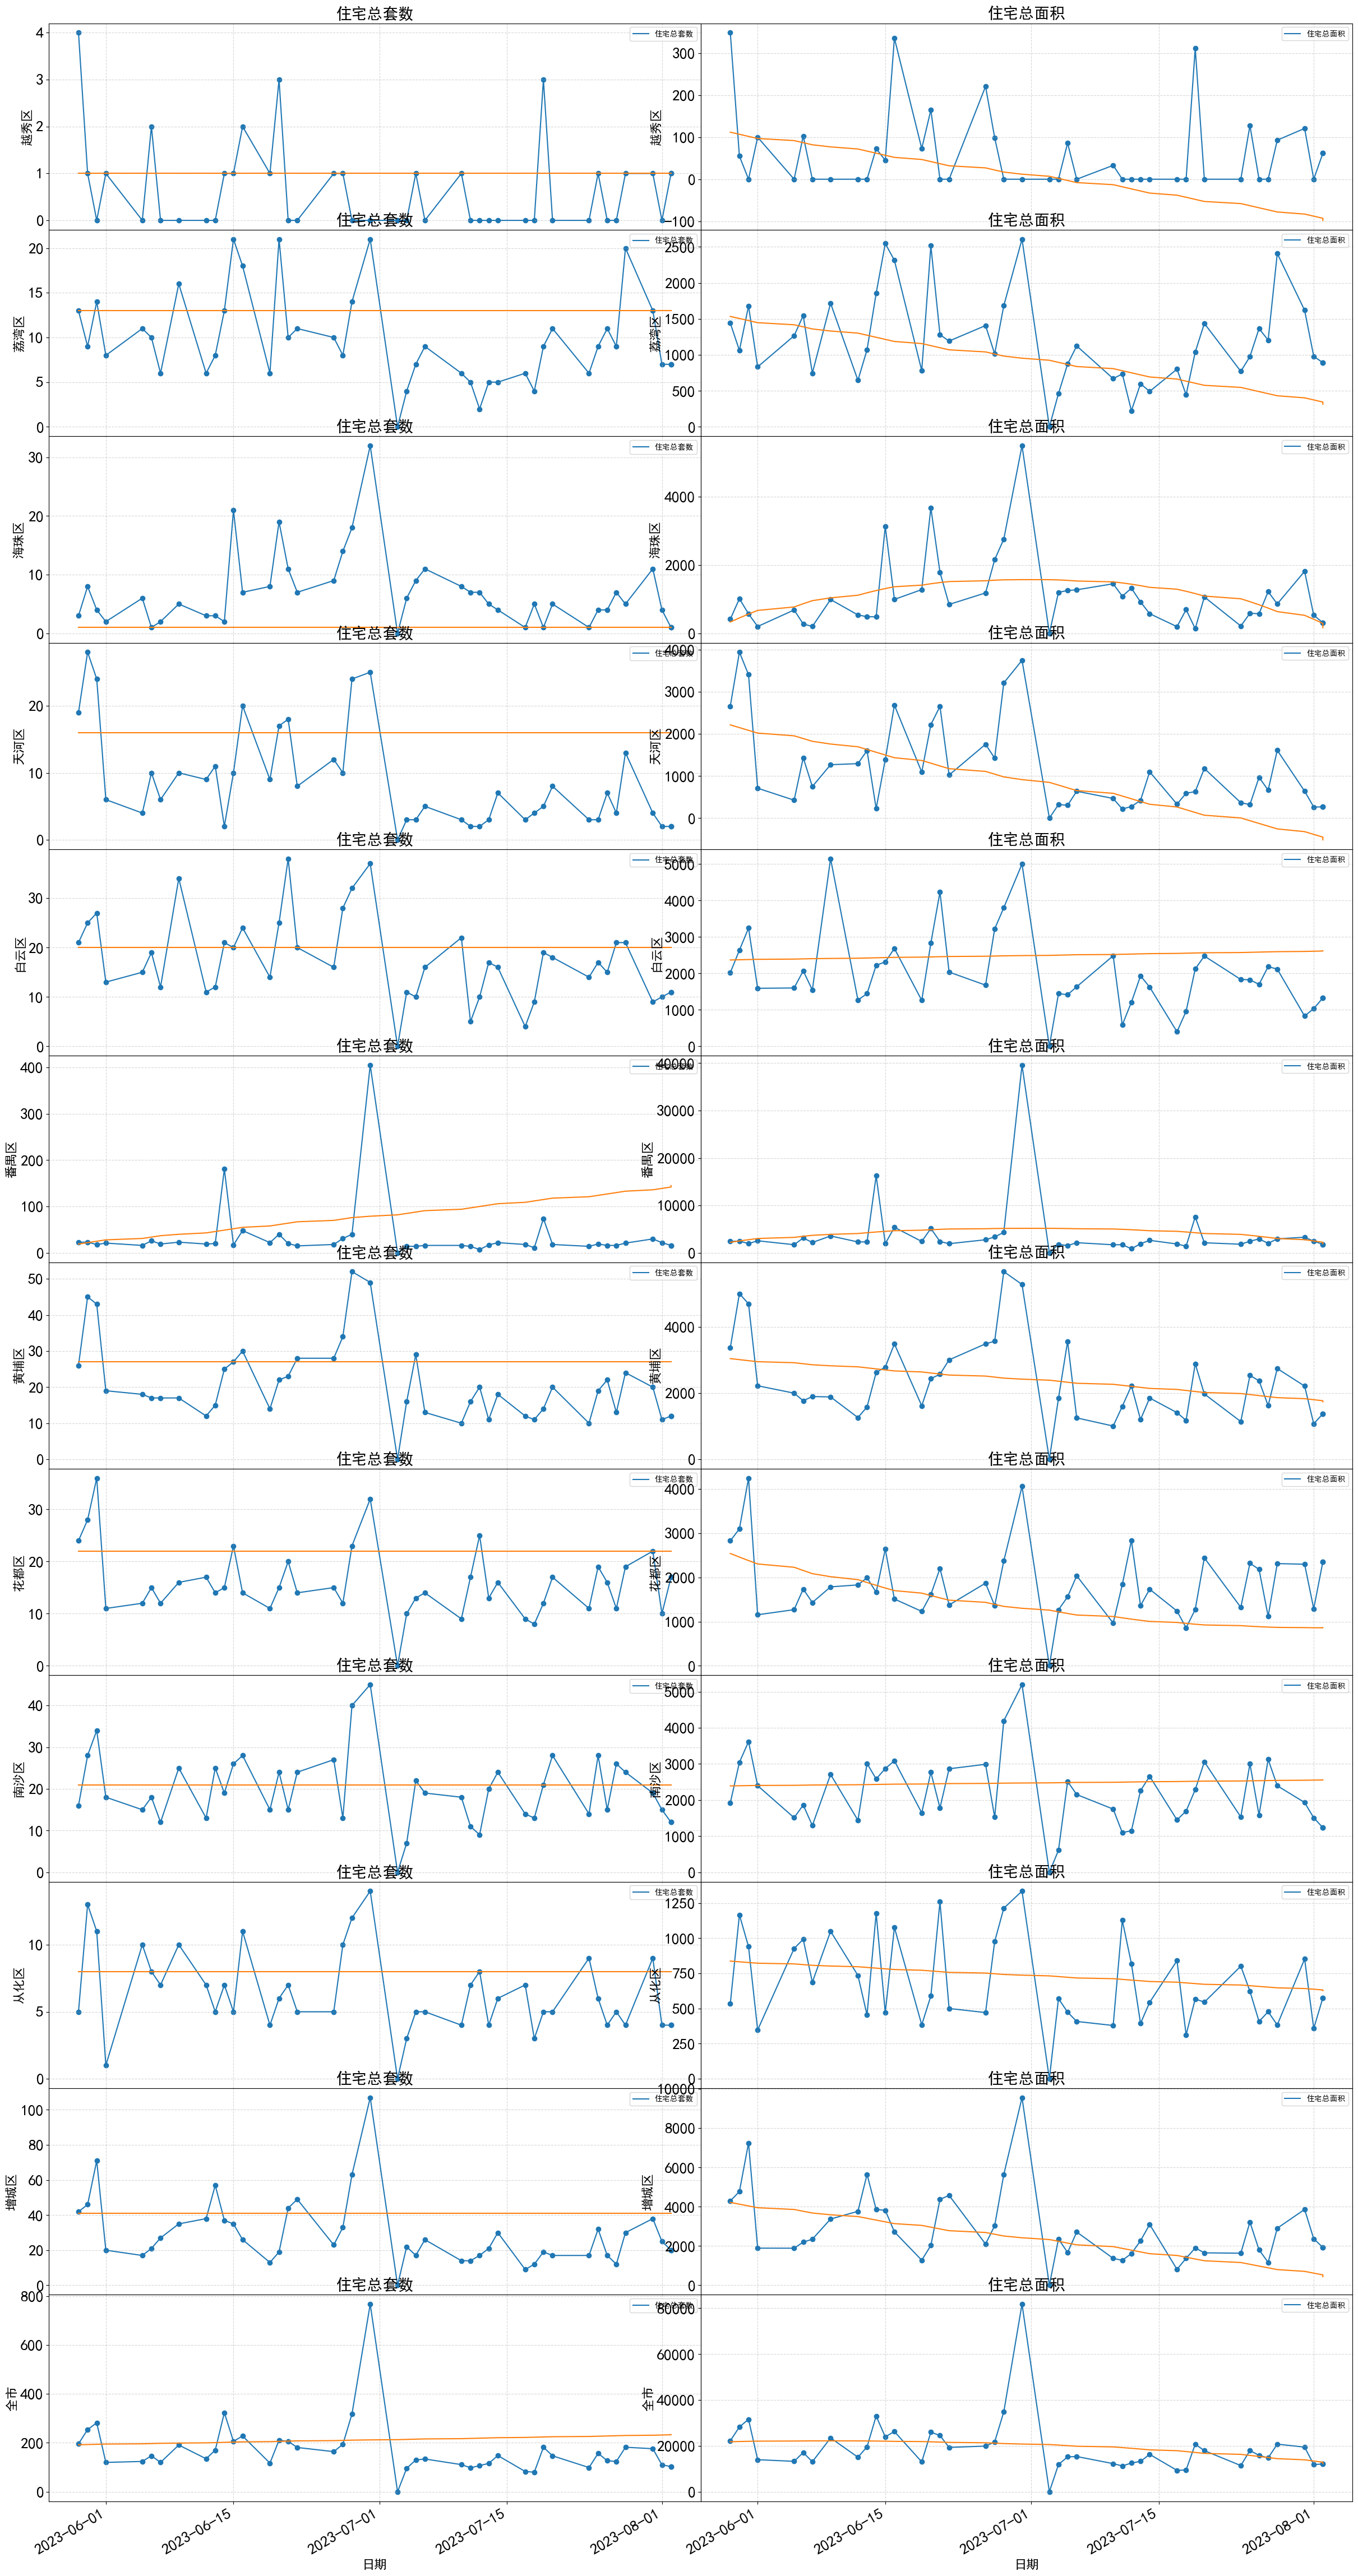

In [5]:
# 广州 已销售 住宅
columns = ['住宅总套数', '住宅总面积']

date = sold_data[show_region_idx].index
show_lineplot(sold_data, date, columns)

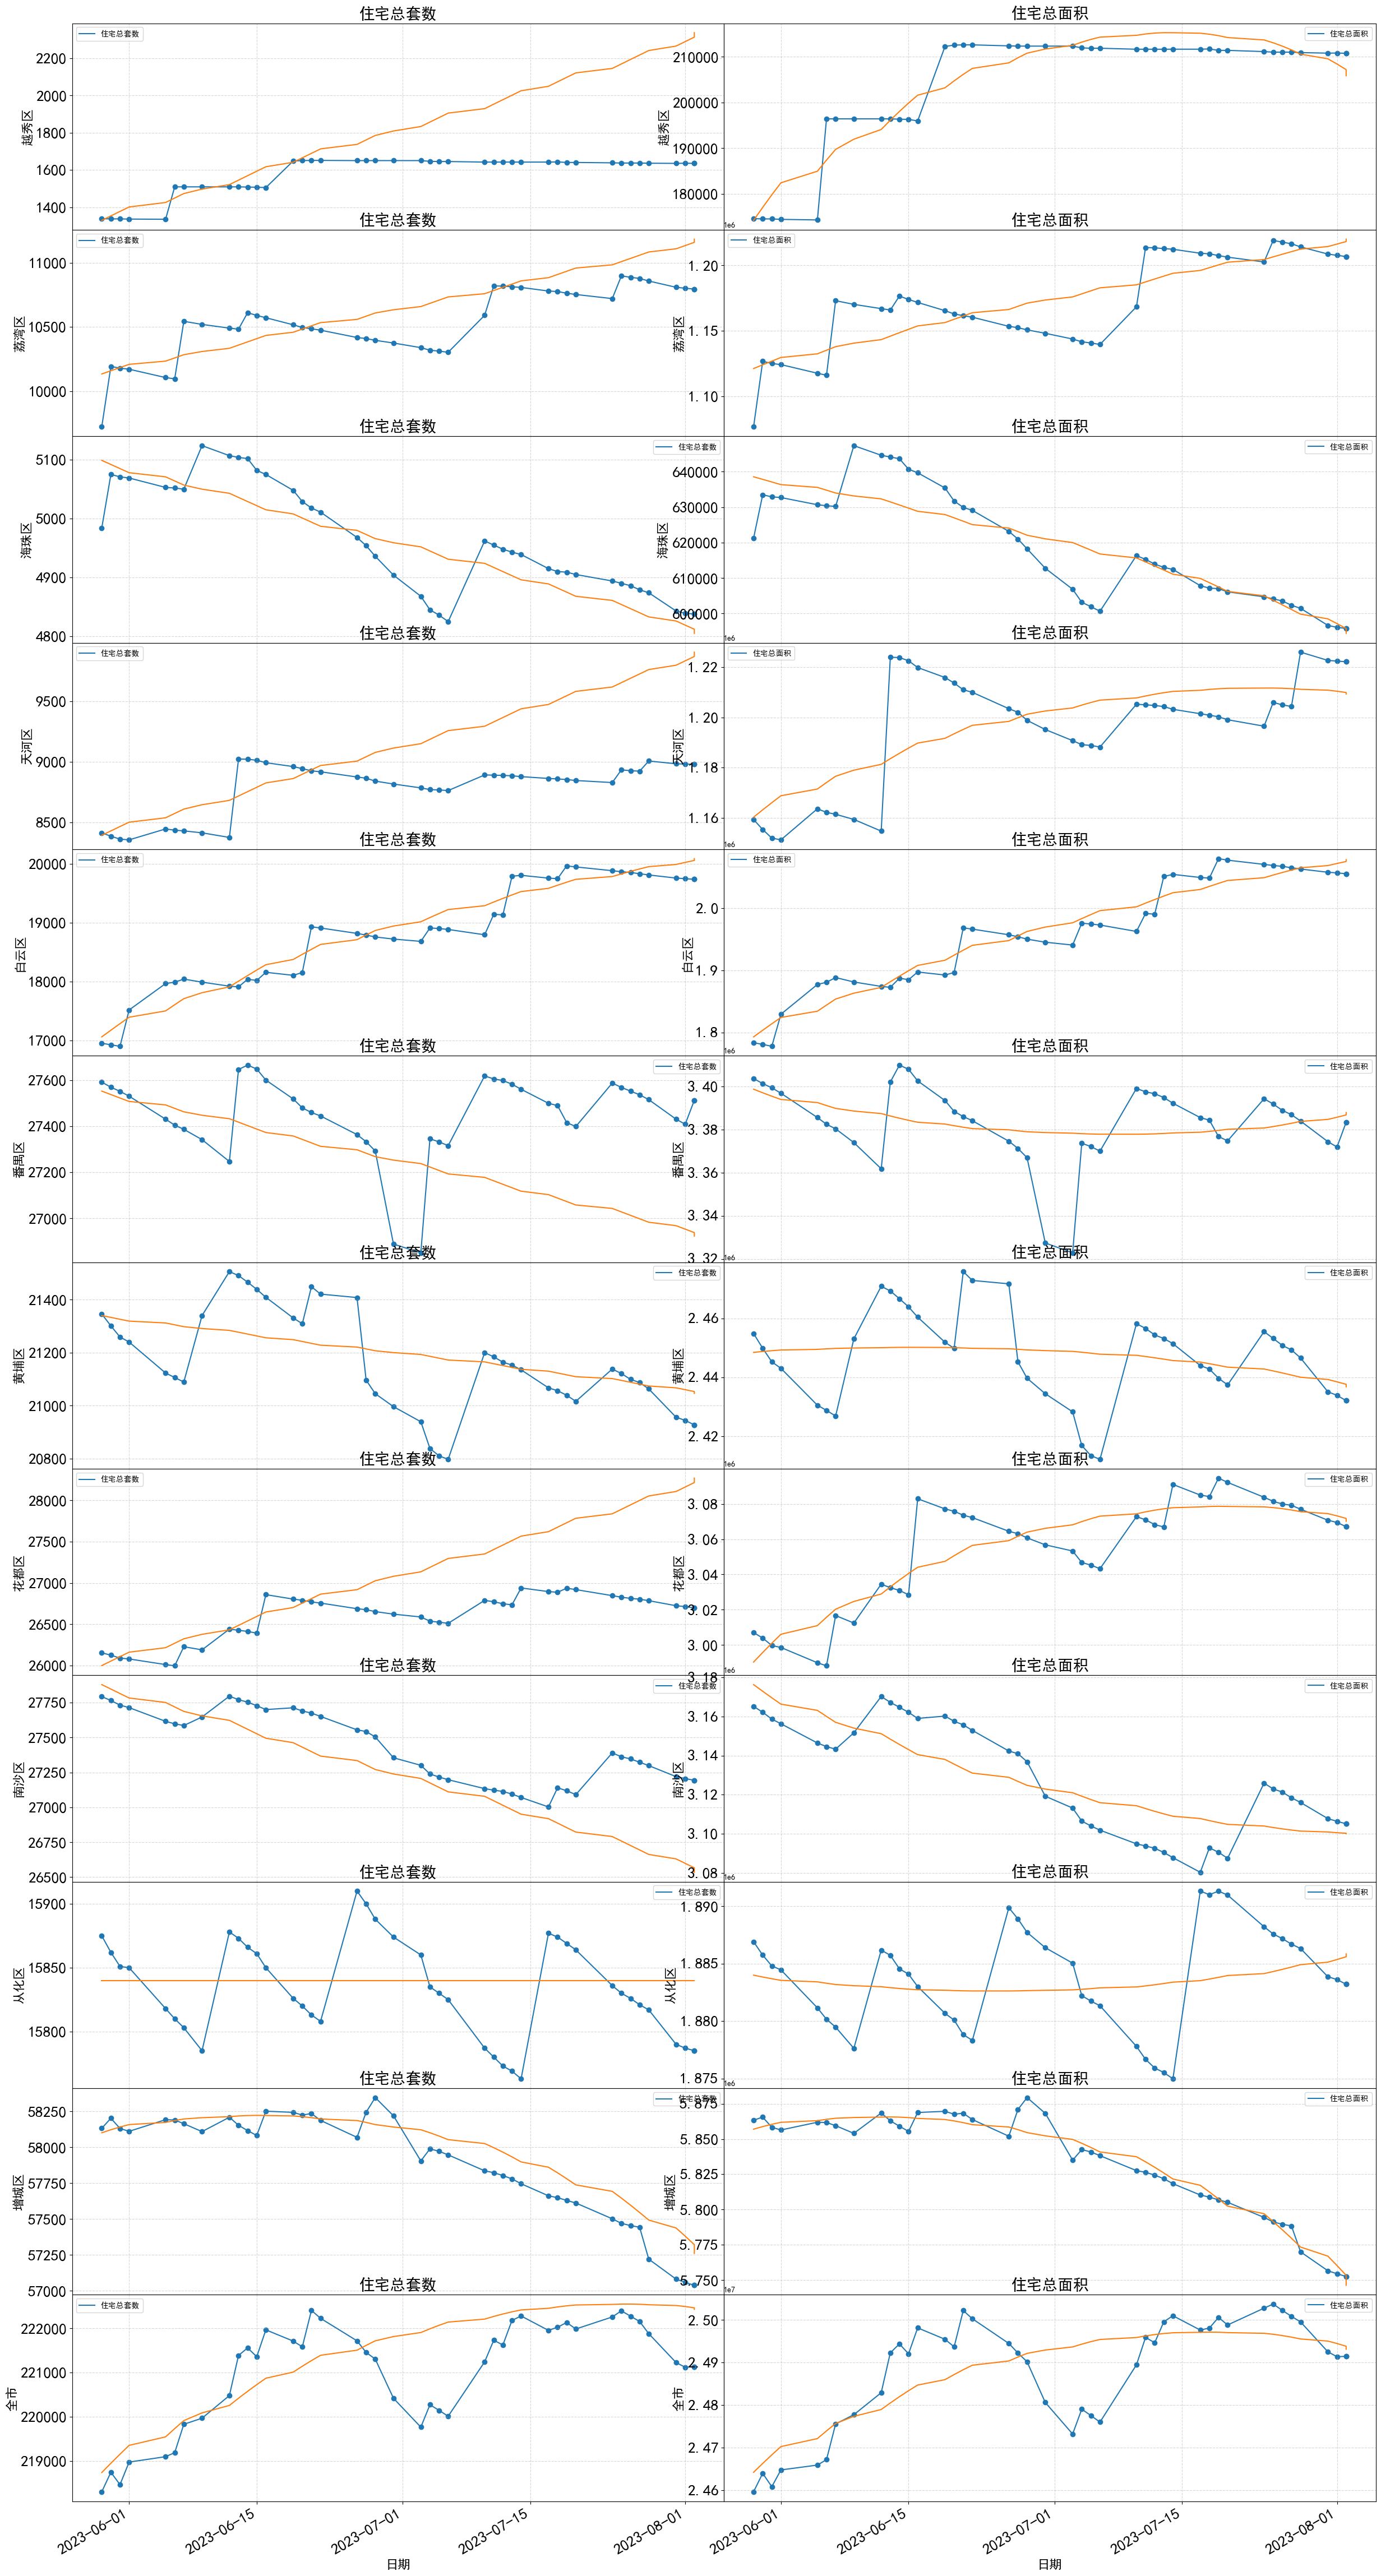

In [6]:
# 广州 未销售 住宅
columns = ['住宅总套数', '住宅总面积']

date = unsold_data[show_region_idx].index
show_lineplot(unsold_data, date, columns)

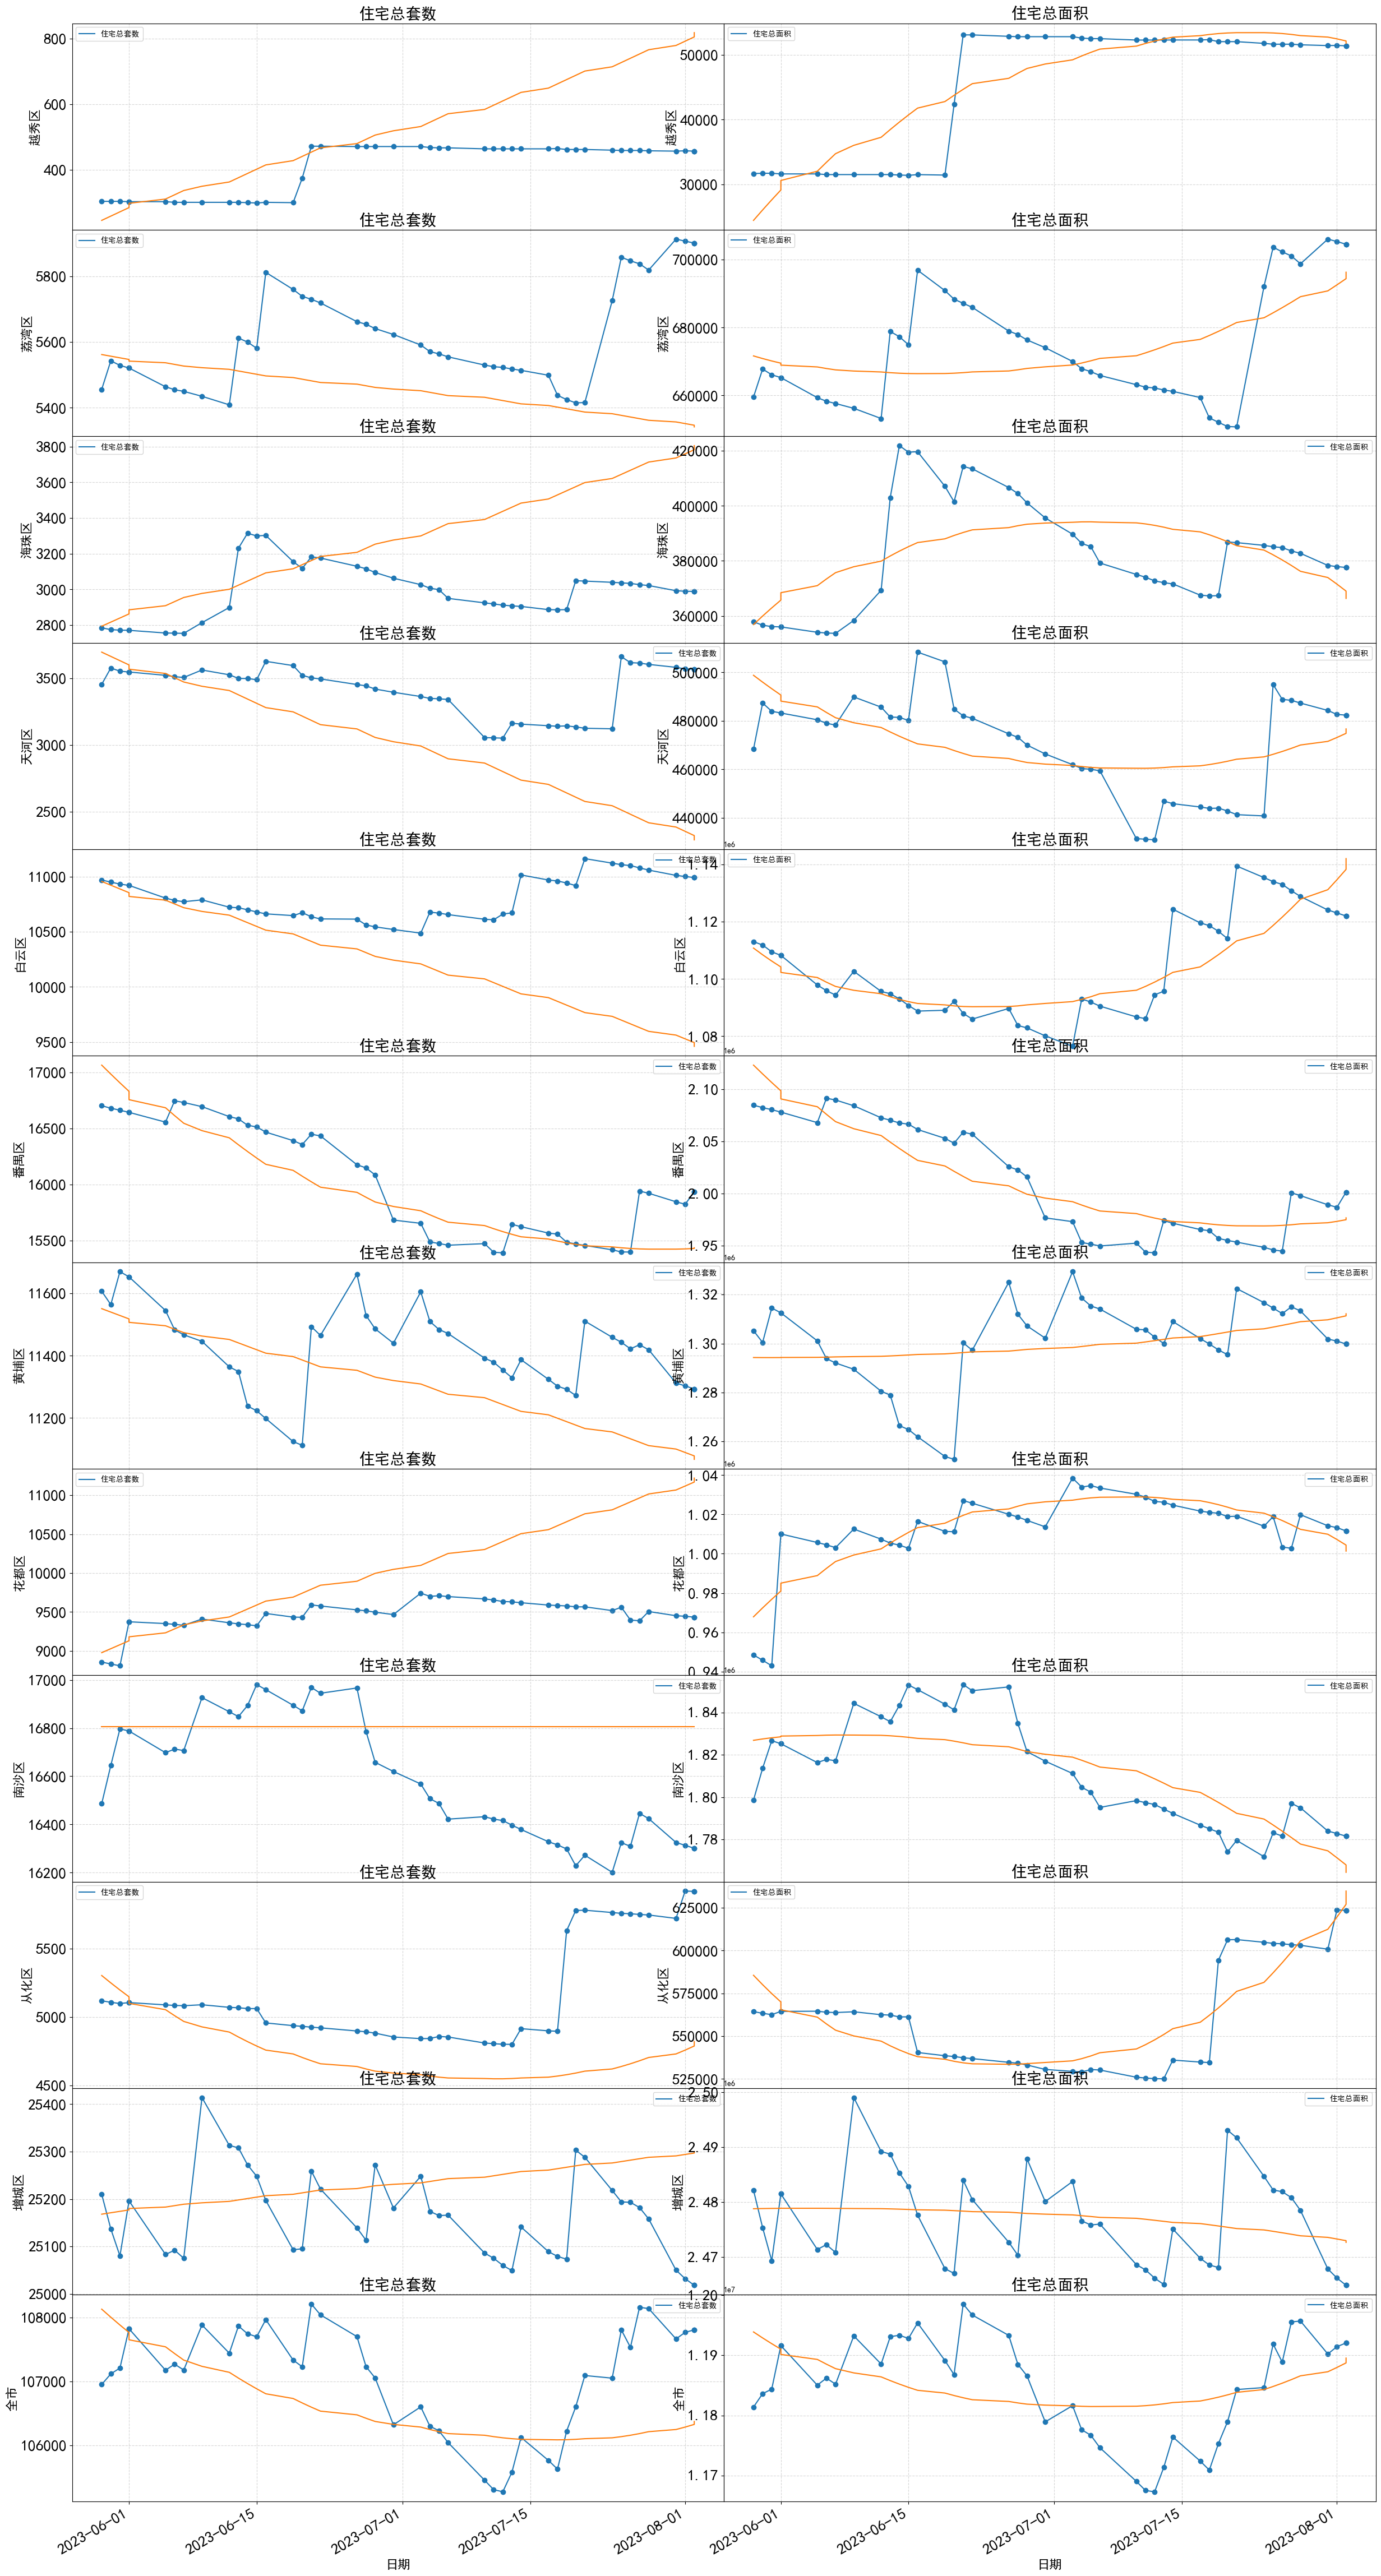

In [7]:
# 广州 可销售 住宅
columns = ['住宅总套数', '住宅总面积']

date = available_data[show_region_idx].index
show_lineplot(available_data, date, columns)

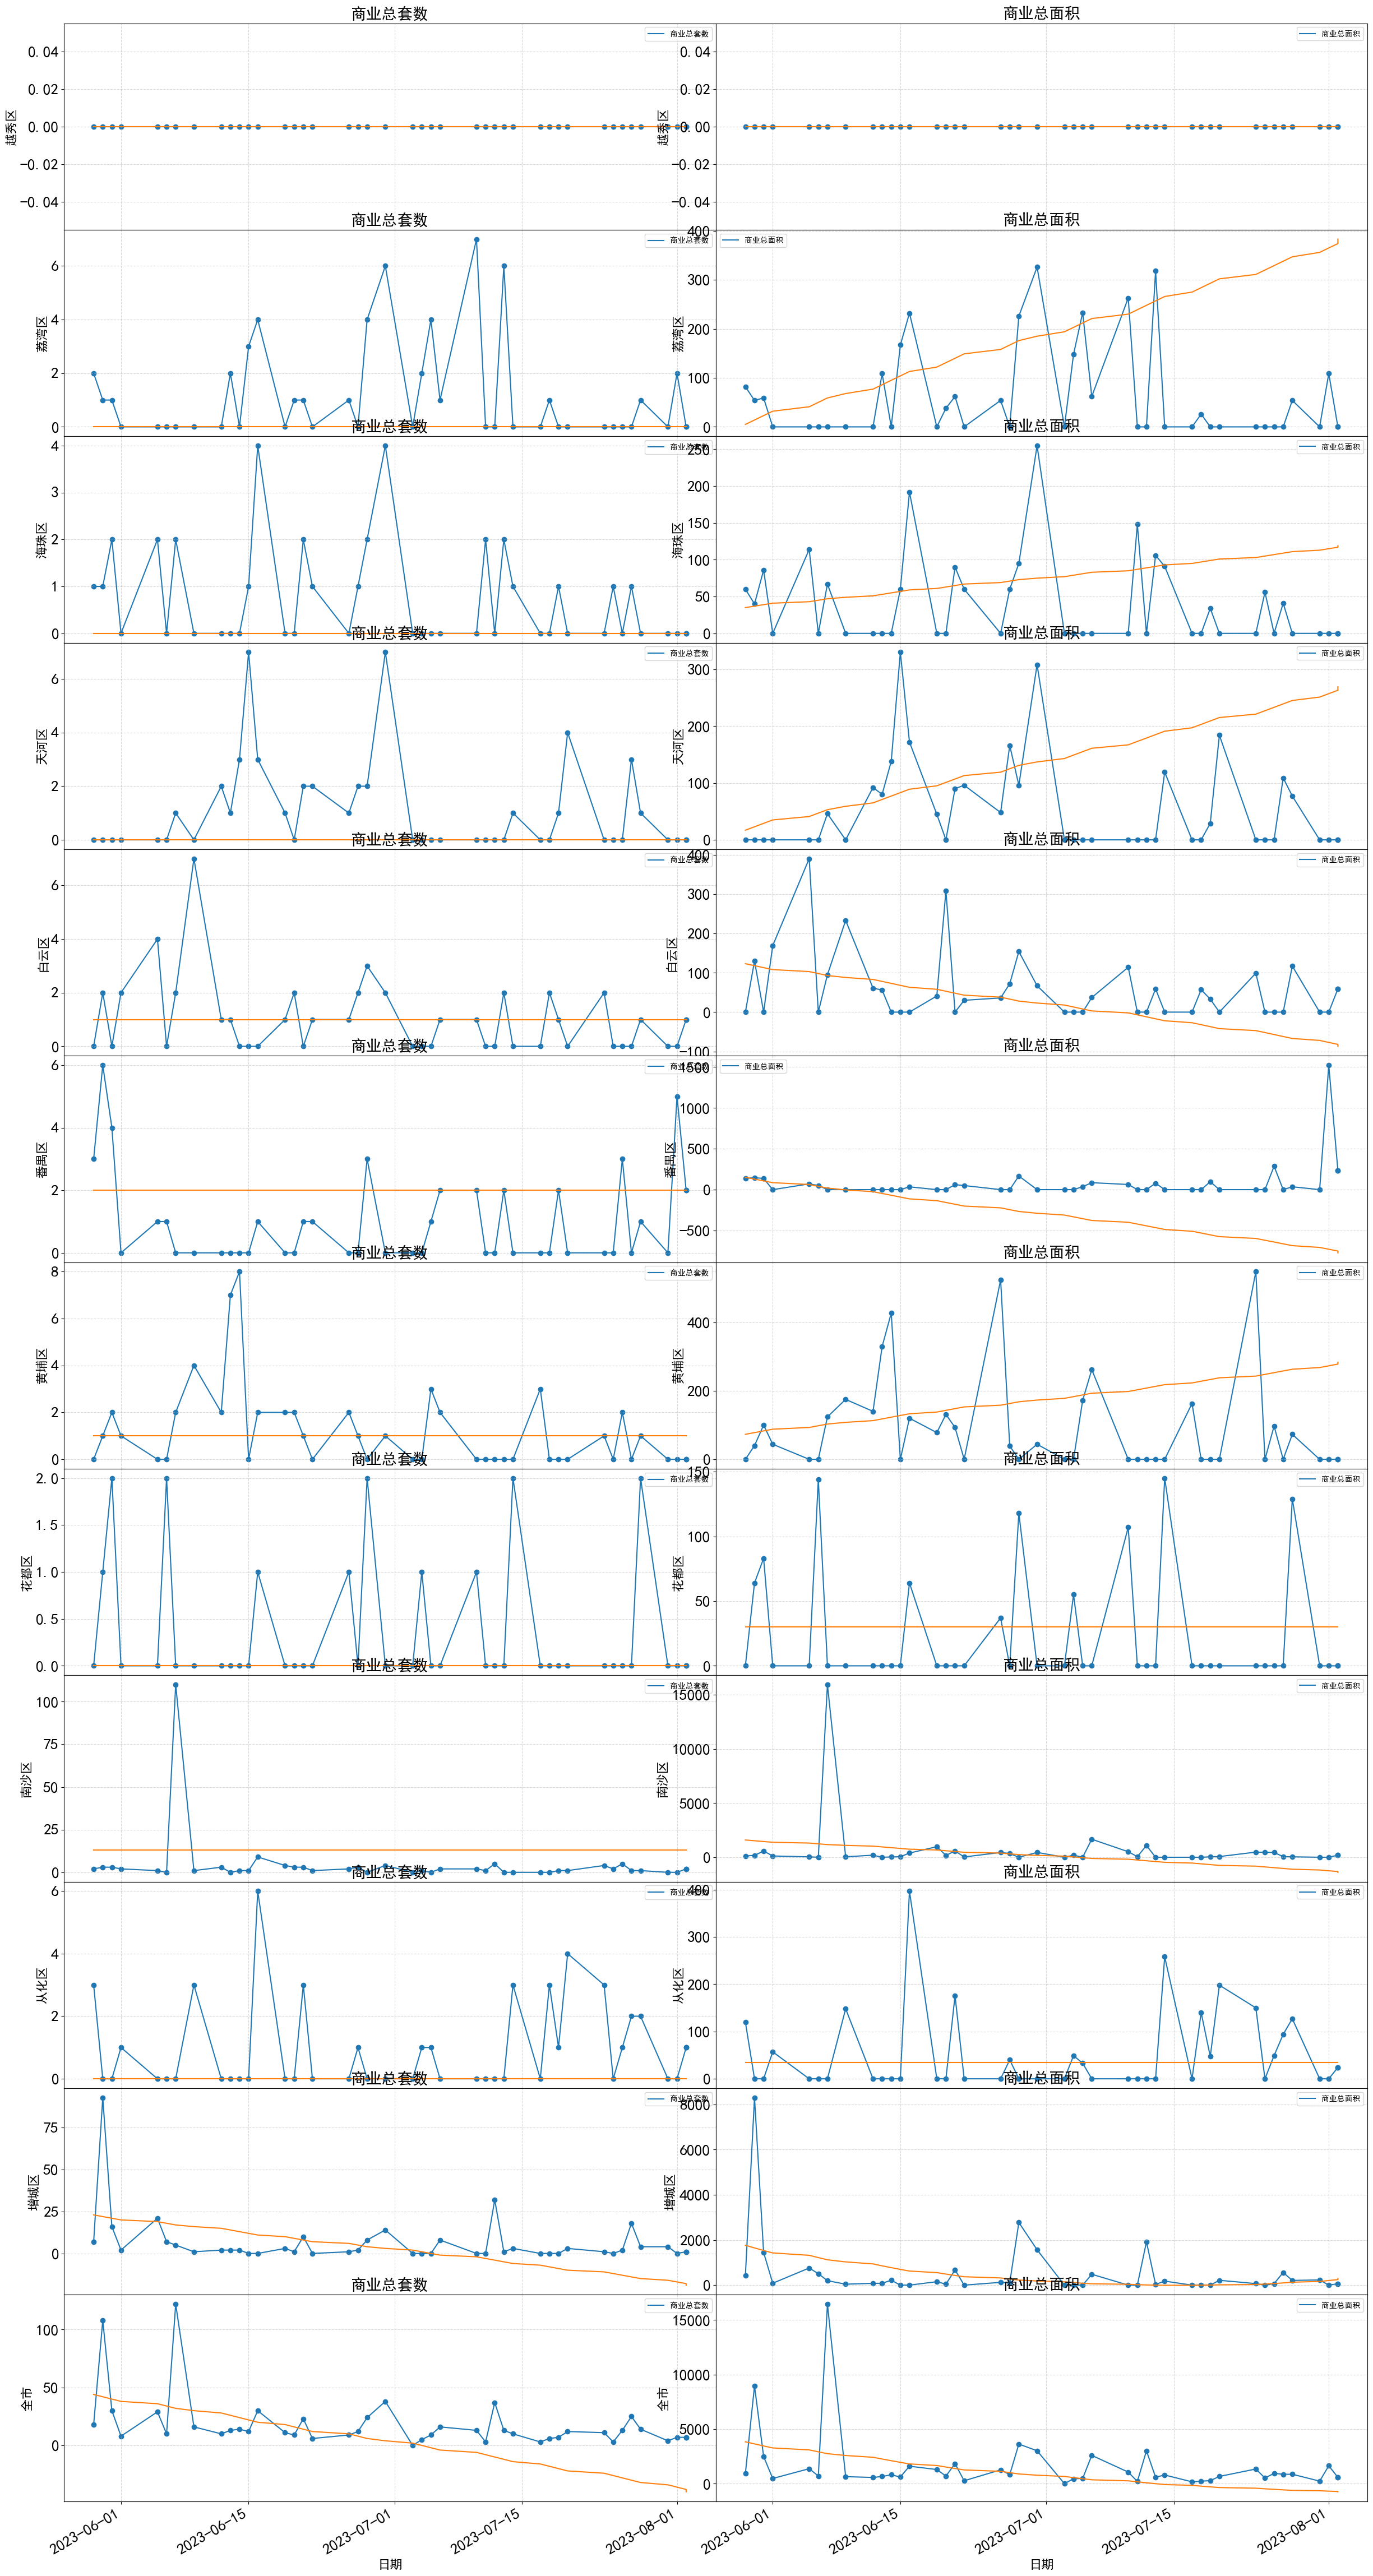

In [8]:
# 广州 已销售 商业房
columns = ['商业总套数', '商业总面积']

date = sold_data[show_region_idx].index
show_lineplot(sold_data, date, columns)

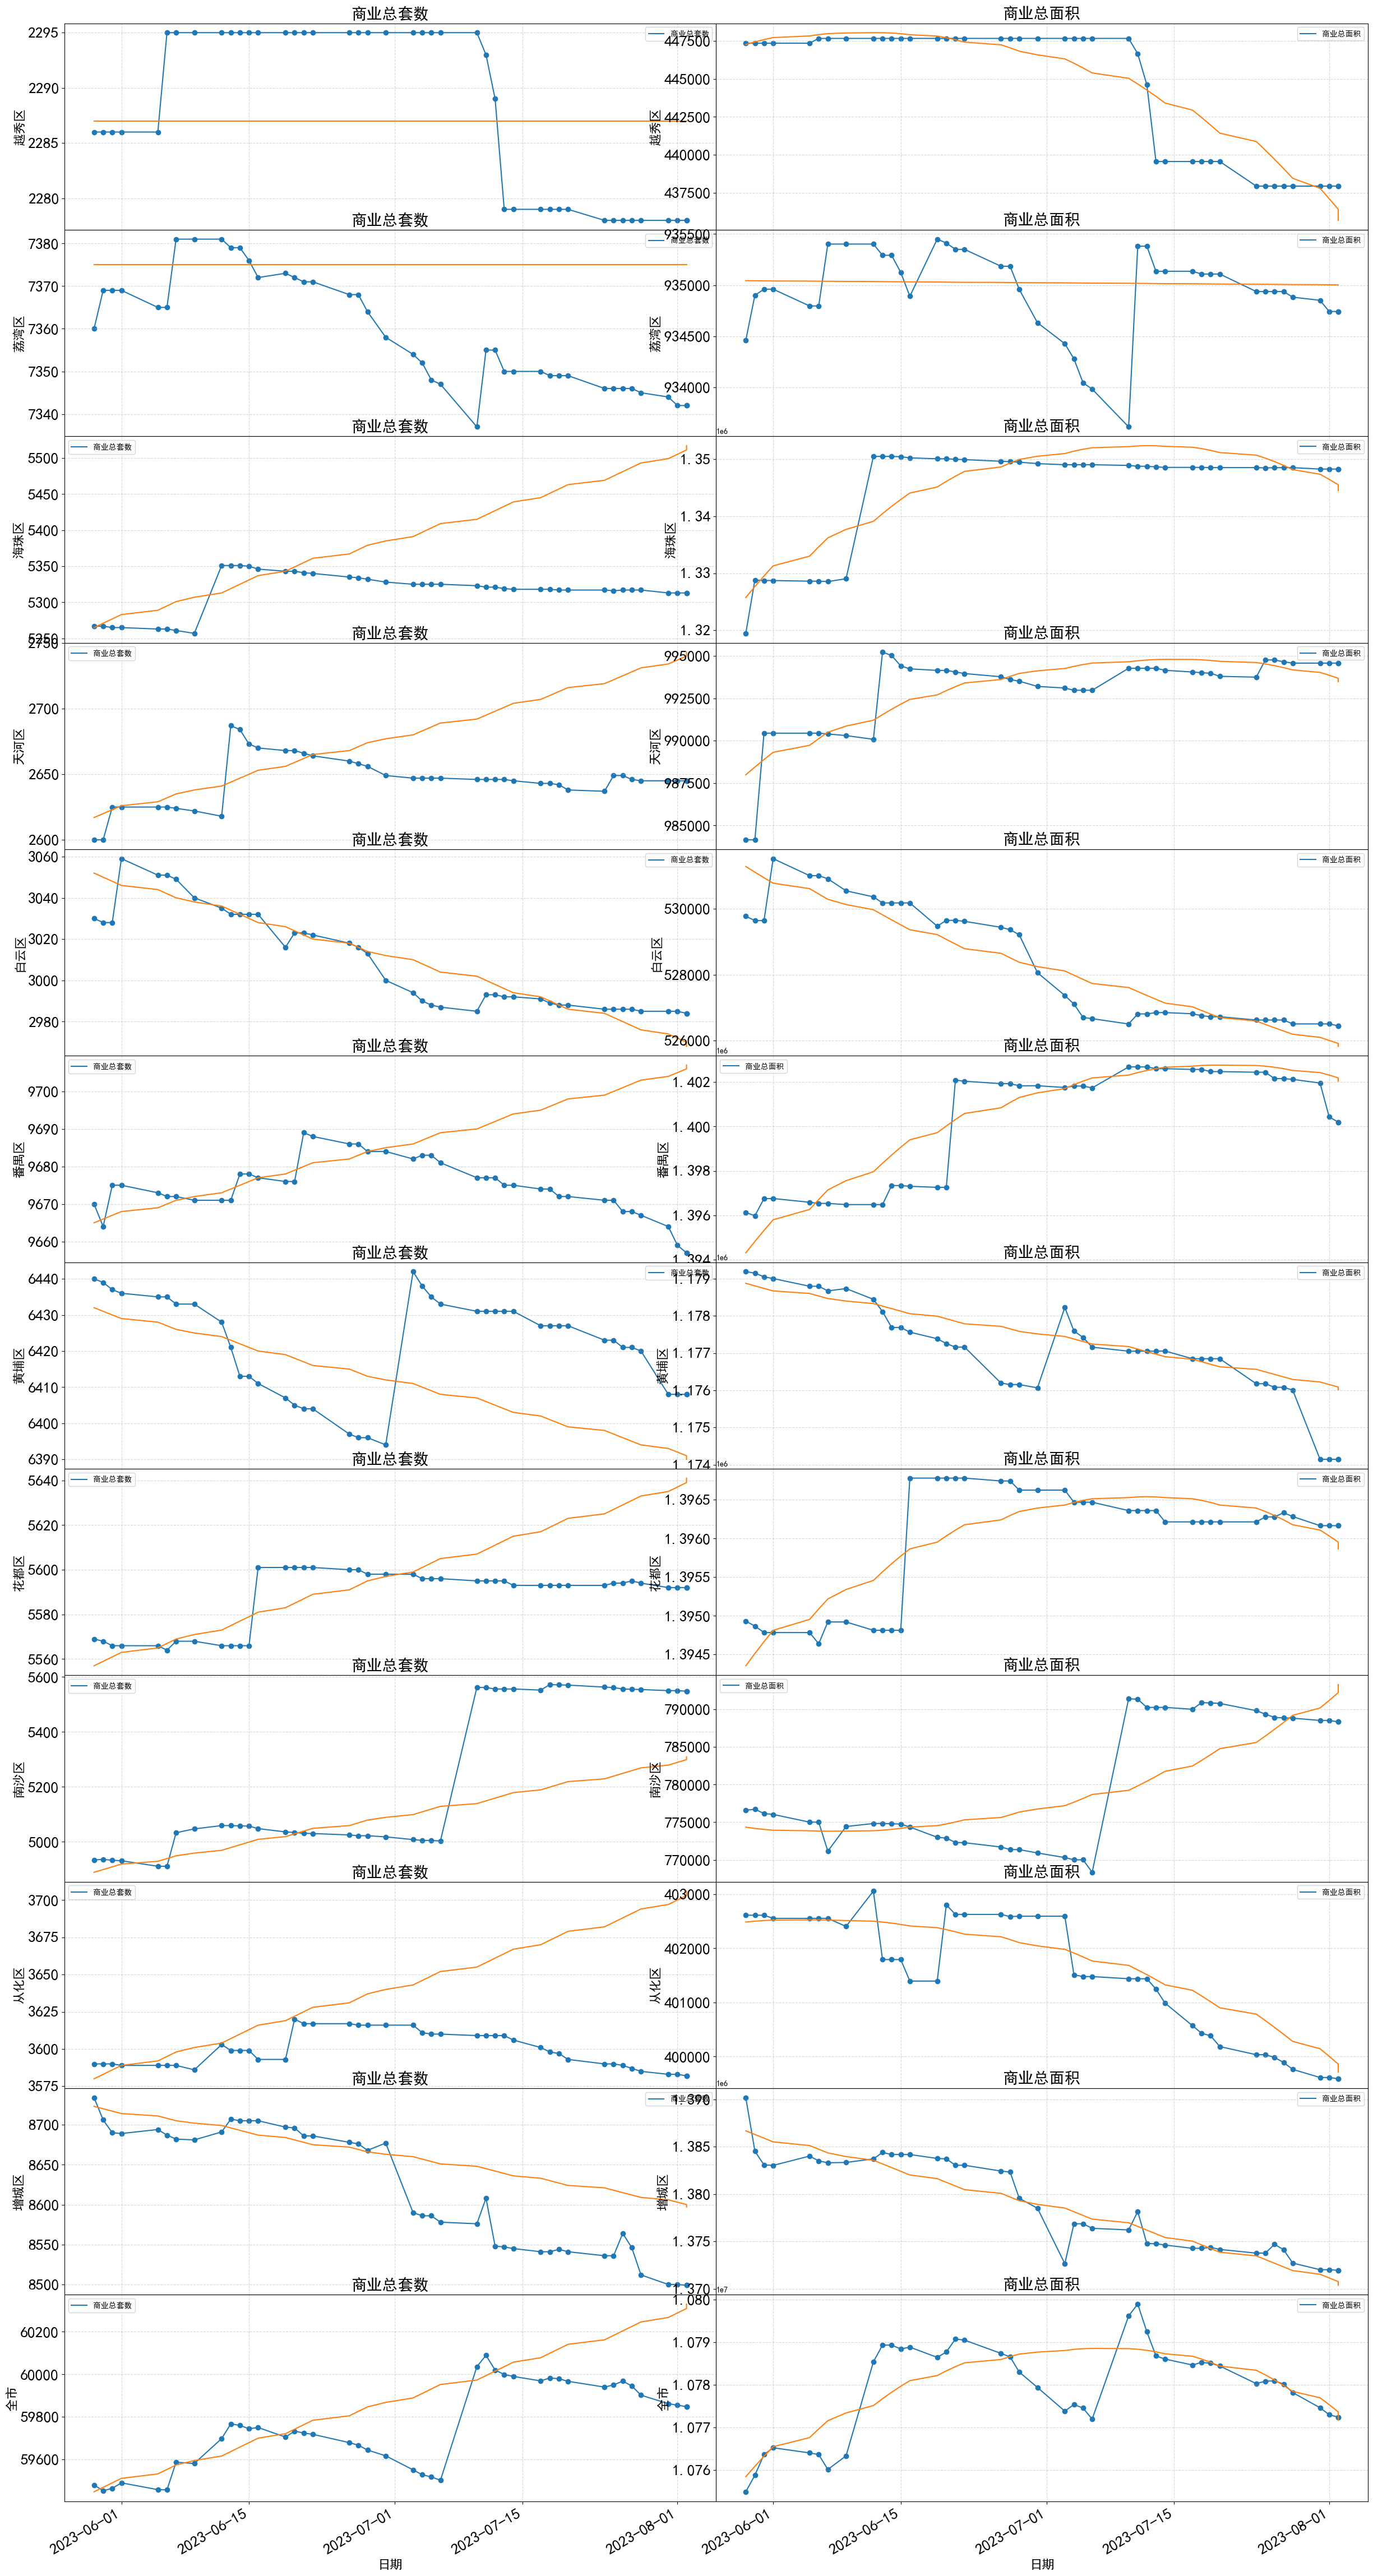

In [9]:
# 广州 未销售 商业房
columns = ['商业总套数', '商业总面积']

date = unsold_data[show_region_idx].index
show_lineplot(unsold_data, date, columns)